In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e11/sample_submission.csv
/kaggle/input/playground-series-s5e11/train.csv
/kaggle/input/playground-series-s5e11/test.csv


## Loading Data

In [54]:
df_sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e11/sample_submission.csv")
df_test = pd.read_csv("/kaggle/input/playground-series-s5e11/test.csv")
df_train = pd.read_csv("/kaggle/input/playground-series-s5e11/train.csv")

## EDA

In [31]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593994 entries, 0 to 593993
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    593994 non-null  int64  
 1   annual_income         593994 non-null  float64
 2   debt_to_income_ratio  593994 non-null  float64
 3   credit_score          593994 non-null  int64  
 4   loan_amount           593994 non-null  float64
 5   interest_rate         593994 non-null  float64
 6   gender                593994 non-null  object 
 7   marital_status        593994 non-null  object 
 8   education_level       593994 non-null  object 
 9   employment_status     593994 non-null  object 
 10  loan_purpose          593994 non-null  object 
 11  grade_subgrade        593994 non-null  object 
 12  loan_paid_back        593994 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 58.9+ MB


## Clean Categorical Data into Numerical for Model

In [55]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ['gender','marital_status','education_level','employment_status','loan_purpose','grade_subgrade']

# Initialize a dictionary to store encoders (optional, useful for inverse_transform later)
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_train[col] = le.fit_transform(df_train[col])
    encoders[col] = le  # Save encoder if you need to transform test data or reverse later

In [56]:
encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_test[col] = le.fit_transform(df_test[col])
    encoders[col] = le  # Save encoder if you need to transform test data or reverse later


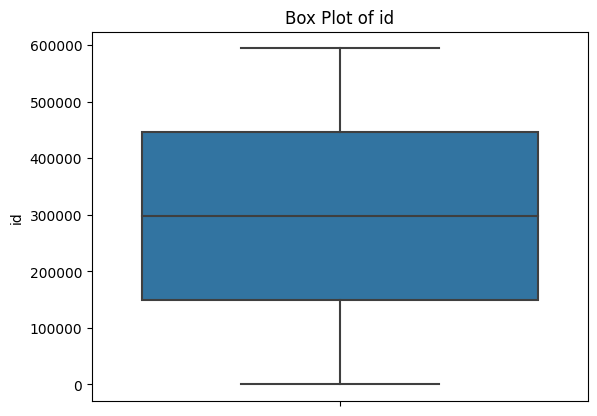

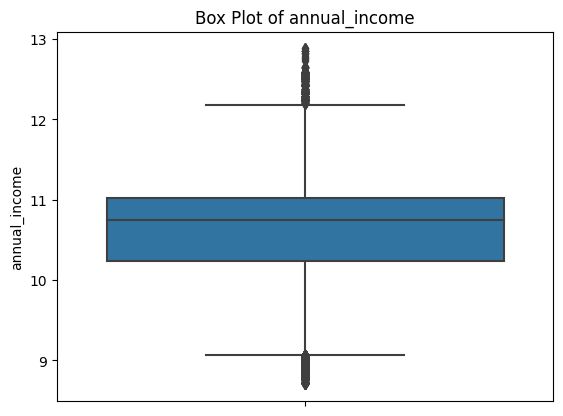

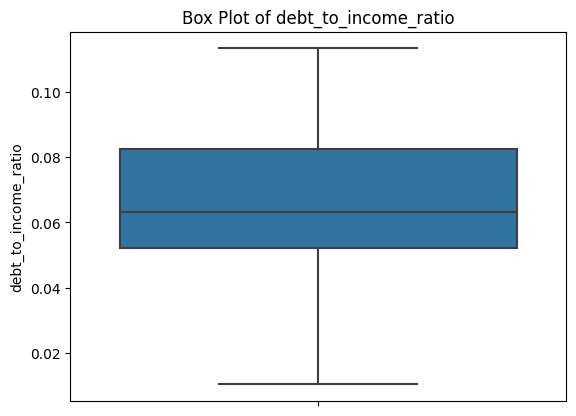

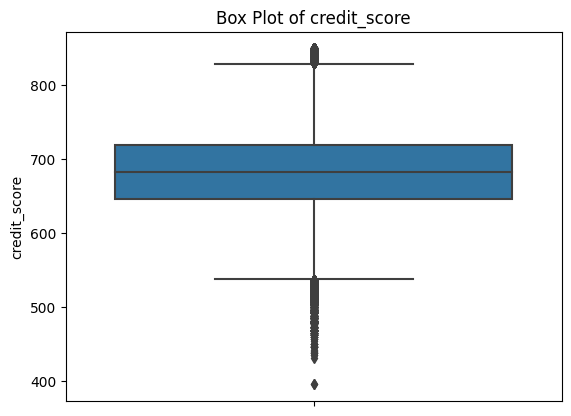

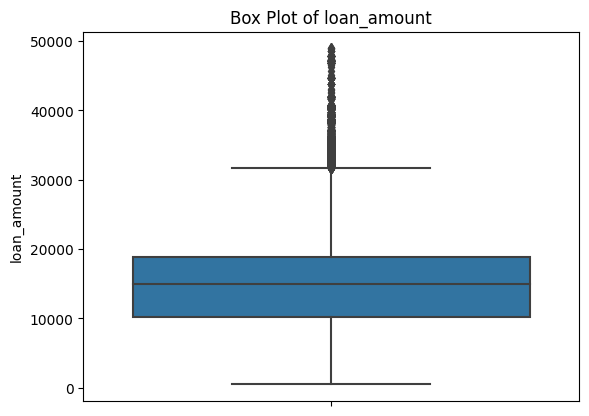

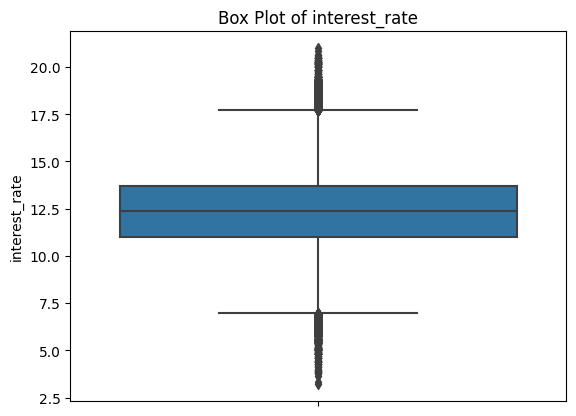

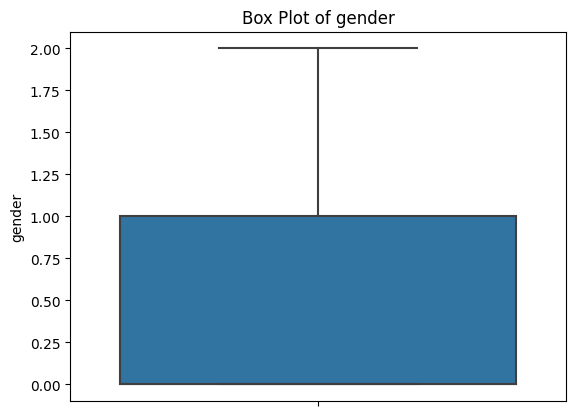

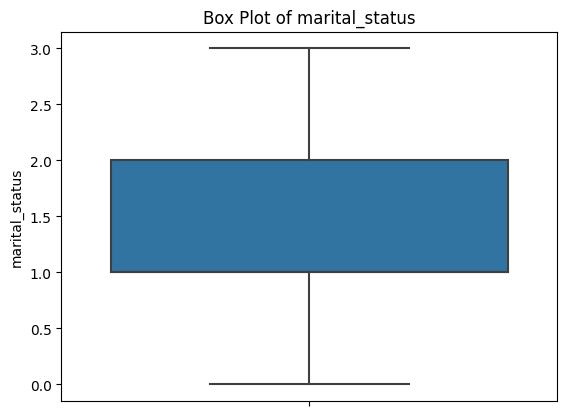

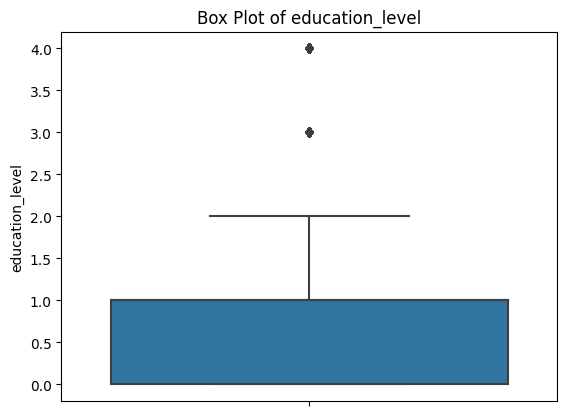

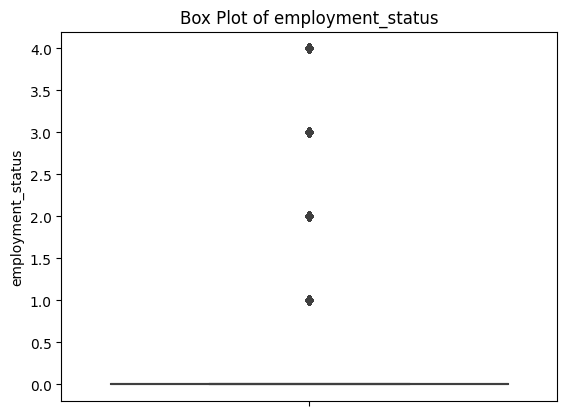

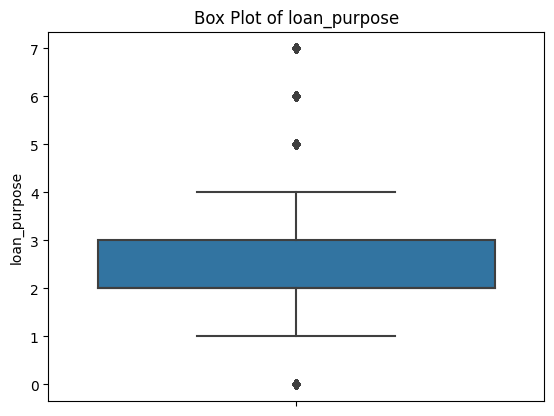

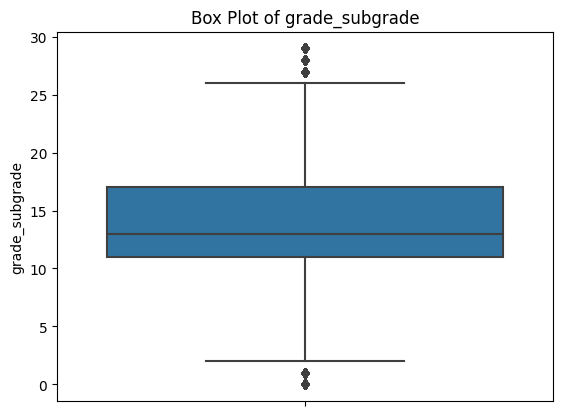

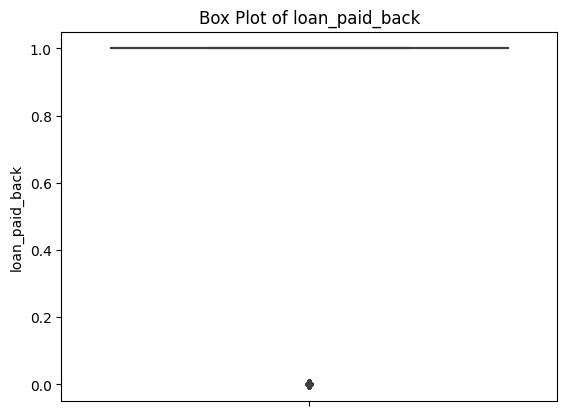

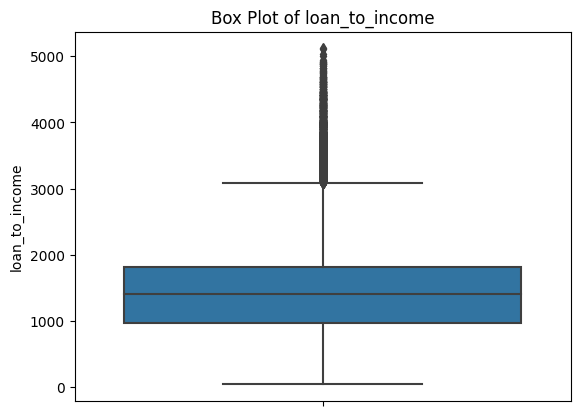

In [44]:
for column in df_train.columns:
    plt.figure() # Create a new figure for each box plot
    sns.boxplot(y=df_train[column]) # Create the box plot for the current column
    plt.title(f'Box Plot of {column}') # Add a title to the plot
    plt.ylabel(column) # Label the y-axis
    plt.show() # Display the plot

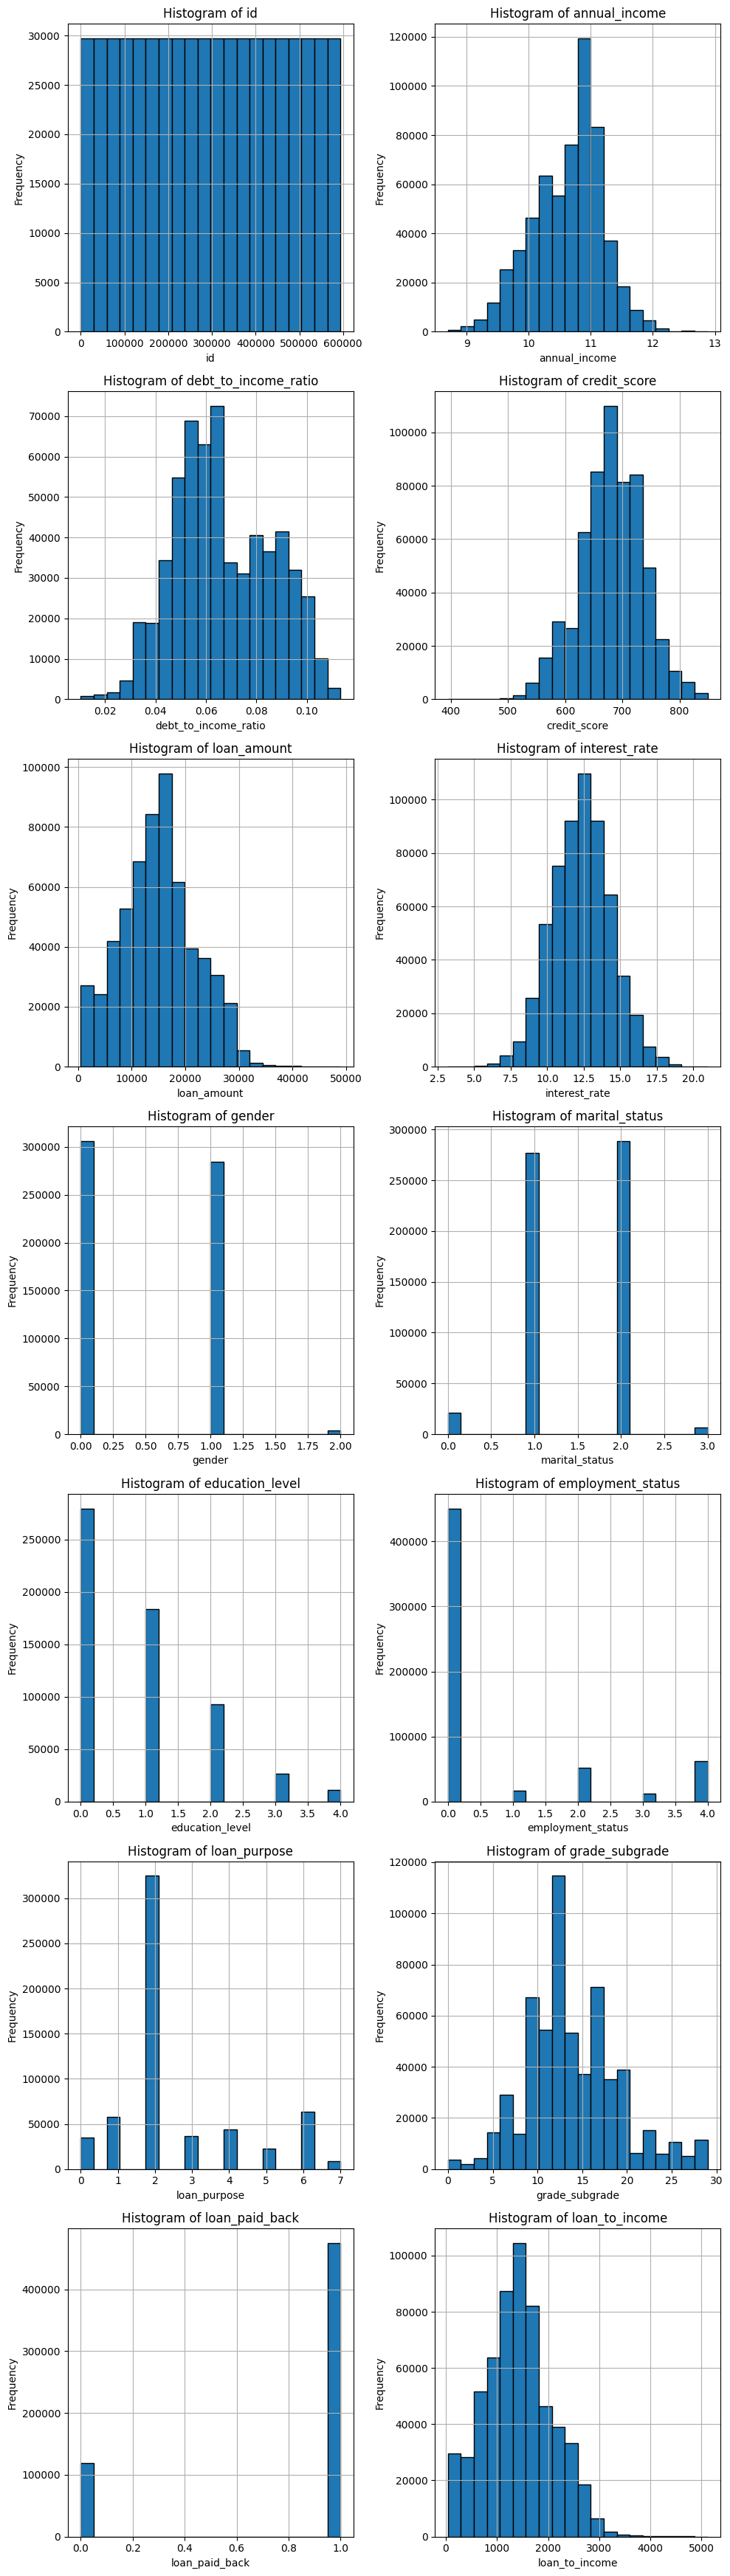

In [45]:
# Select only numerical columns for plotting histograms
numerical_cols = df_train.select_dtypes(include=np.number).columns

# Create a figure and a set of subplots
# You can adjust the layout (nrows, ncols) and figsize as needed
n_cols = len(numerical_cols)
n_rows = (n_cols + 1) // 2  # Adjust for a 2-column layout, or set explicitly
fig, axes = plt.subplots(nrows=n_rows, ncols=2, figsize=(10, 5 * n_rows))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

# Loop through each numerical column and plot a histogram
for i, col in enumerate(numerical_cols):
    ax = axes[i] # Get the current subplot axis
    df_train[col].hist(ax=ax, bins=20, edgecolor='black') # Plot histogram on the current axis
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Hide any unused subplots if the number of columns is not a perfect fit for the grid
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

In [57]:
df_train['annual_income'] = np.log1p(df_train['annual_income'])

from scipy.stats import yeojohnson
df_train['debt_to_income_ratio'],_ = yeojohnson(df_train['debt_to_income_ratio'])

## Correlation of variables

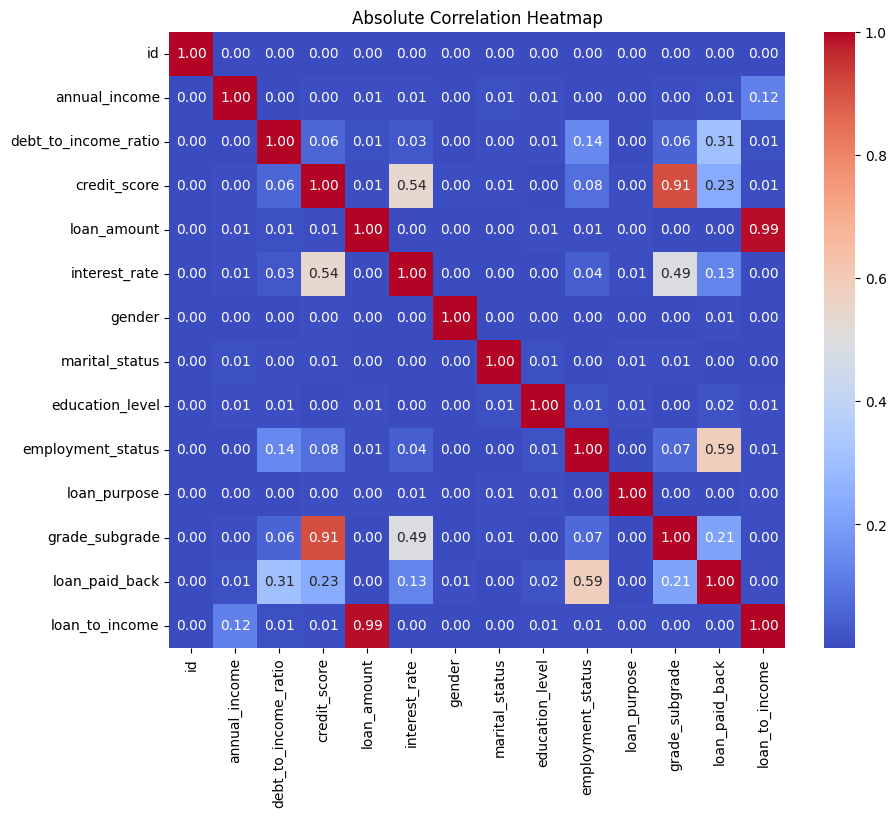

In [47]:
df_train.corr().abs().unstack().sort_values(ascending=False)
import seaborn as sns
import matplotlib.pyplot as plt

# Compute absolute correlation matrix
corr_matrix = df_train.corr().abs()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Absolute Correlation Heatmap")
plt.show()

In [70]:
df_train.isna().sum()


id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [71]:
import numpy as np

# Count positive and negative infinity
print("Positive inf count:")
print(np.isinf(df_train).sum())

print("\nTotal inf values:")
print(np.isinf(df_train).sum().sum())

Positive inf count:
id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

Total inf values:
0


## Find out best parameters for model

In [59]:
drop_col = ['id','grade_subgrade']
target = ['loan_paid_back']

X_train = df_train.drop(columns=drop_col + target)  
X_test = df_test.drop(columns=drop_col)
y_train = df_train['loan_paid_back']

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [4,5,6],
    'learning_rate': [0.1,0.2],
    'n_estimators': [200,300,400],
    'subsample': [1.0],
    'reg_alpha': [1.0],
    'reg_lambda': [1.0]
}

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    verbose=1,
    n_jobs=-1  
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best AUC score:", grid_search.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


KeyboardInterrupt: 

## Model Train and Predict

In [60]:
from xgboost import XGBClassifier

model = XGBClassifier(
    max_depth = 5,
    learning_rate = 0.1,
    n_estimators = 500,
    subsample = 0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',  # logistic regression-style loss
    eval_metric='auc',        # evaluation metric for binary classification
    use_label_encoder=False      # suppress legacy warning
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # if you need probabilities

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print("Mean AUC:", scores.mean())

Mean AUC: 0.9214692016104861


## Feature Engineering

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

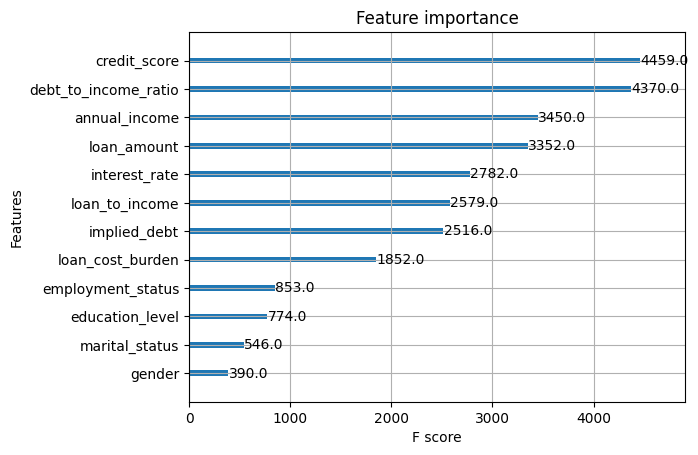

In [103]:
from xgboost import plot_importance
plot_importance(model)

Text(-132.31944444444443, 0.5, 'Features')

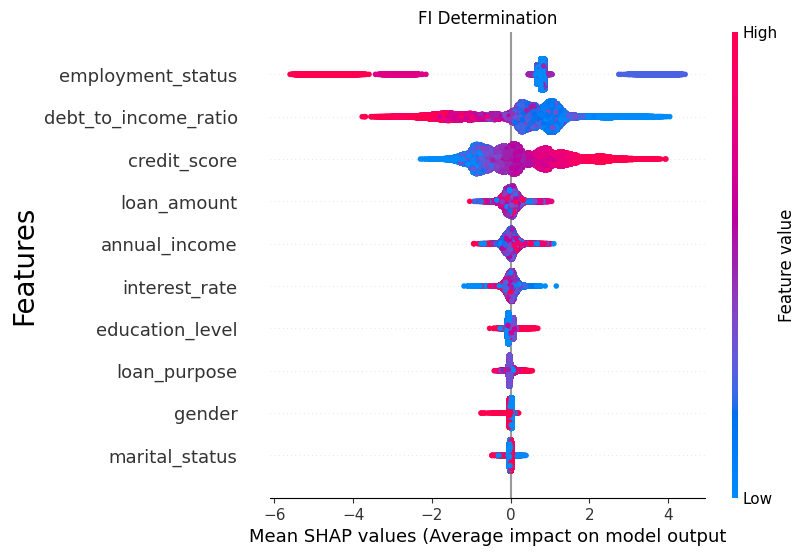

In [16]:
import shap
X_sample = X_test.sample(n=100, random_state=42)
explainer = shap.TreeExplainer(model, feature_perturbation='interventional')
shap_values = explainer.shap_values(X_sample)

fig = shap.summary_plot(shap_values, X_test, show=False, class_names=['high adaptivity','med adaptivity','low adaptivity'])
plt.title('FI Determination')
plt.xlabel('Mean SHAP values (Average impact on model output')
plt.ylabel('Features',fontsize=20)

## Run model again with feature engineering

In [123]:
X_train = X_train.drop(columns=['gender','marital_status','education_level'])  
X_test = X_test.drop(columns=['gender','marital_status','education_level'])

In [124]:
model = XGBClassifier(
    max_depth = 6,
    learning_rate = 0.1,
    n_estimators = 500,
    subsample = 0.8,
    objective='binary:logistic',  # logistic regression-style loss
    eval_metric='auc',  
    colsample_bytree=0.8,
    use_label_encoder=False,       # suppress legacy warning
    n_jobs=-1
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  

from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print("Mean AUC:", scores.mean())

Mean AUC: 0.9209779098473765


## Model differences

In [ ]:
X = df_train.drop(columns=['loan_paid_back', 'id', 'grade_subgrade']) 
y = df_train['loan_paid_back'] 
X_train, X_val, y_train, y_val = train_test_split( X, y, test_size=0.2, random_state=42, stratify=y )

In [180]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

# Define parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'num_leaves': 30,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'verbose': -1
}

# Train the model
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'val']
)

# Predict and evaluate
y_pred = model.predict(X_val)
y_prob = model.predict(X_test)[:, 1]
auc_score = roc_auc_score(y_val, y_pred)
print(f"AUC: {auc_score:.5f}")


[LightGBM] [Fatal] The number of features in data (9) is not the same as it was in training data (10).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.


LightGBMError: The number of features in data (9) is not the same as it was in training data (10).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [175]:
print(y_pred)

[0.96651663 0.99038332 0.94446753 ... 0.98225951 0.99708929 0.57228567]


## Export Data for Submission

In [ ]:
submission = pd.DataFrame({
    'id': df_test['id'],
    'loan_paid_back': y_pred
})

submission.to_csv('submissionlgb.csv', index=False)

In [166]:
df_sample_submission.head()

,id,loan_paid_back
0,593994,0
1,593995,0
2,593996,0
3,593997,0
4,593998,0
